## Final Project: Deterministic Neural Network

**Student:** Guillem Amat (ga98), Sebastian Soriano Perez(ss72)

<br>

**Import packages**

In [1]:
#Regular Packages
from typing import List, Dict, Tuple
from string import punctuation
import pandas as pd
import numpy as np
import tarfile
import requests
import pdb
import re
import os

In [2]:
#Torch Packages
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

In [4]:
from preprocessing import text_preprocessing, dictionary_mapping, pad

<br>

## STEP 5: IMDB Movie Review Dataset

**Importing Data**

In [5]:
train = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'imdb5k_train.csv'))
test  = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'imdb5k_test.csv'))

**Text Preprocessing**

In [6]:
train = text_preprocessing(train, text_column='text')
test  = text_preprocessing(test,  text_column='text')

**Vocabulary Dictionary Mapping**

In [7]:
word2int, word4review = dictionary_mapping(train, test)

**Encoding Reviews & Labels**

In [8]:
encoded_review = [[word2int[word] for word in review] for review in word4review]

In [9]:
X_train , X_test = encoded_review[:5000], encoded_review[5000:]

In [10]:
y_train = [1 if label == 'pos' else 0 for label in train['label'].tolist()]
y_test  = [1 if label == 'pos' else 0 for label in test['label'].tolist()]

**Exploratory Data Analysis**

In [11]:
import matplotlib.pyplot as plt

In [12]:
lengths = [len(x) for x in encoded_review]

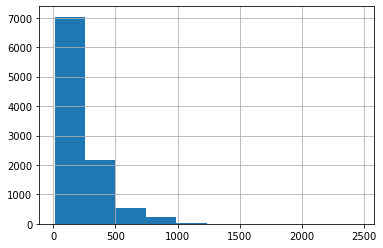

In [13]:
#Think of a better plot
pd.Series(lengths).hist()
plt.show()

In [14]:
pd.Series(lengths).describe()

count    10000.000000
mean     232.957800  
std      175.165521  
min      10.000000   
25%      125.000000  
50%      174.000000  
75%      284.000000  
max      2459.000000 
dtype: float64

**Removing Outliers**

In [15]:
outlier = 500
#Remove outlier reviews: [10 words < review < 500 words]
train_outliers = [True if len(x)<=outlier else False for x in X_train]
test_outliers  = [True if len(x)<=outlier else False for x in X_test]

In [16]:
#Train outlier removal
X_train = [x for x, y in zip(X_train, train_outliers) if y == True]
y_train = [x for x, y in zip(y_train, train_outliers) if y == True]

#Test outlier removal
X_test = [x for x, y in zip(X_test, test_outliers) if y == True]
y_test = [x for x, y in zip(y_test, test_outliers) if y == True]

**Padding**

In [17]:
X_train = pad(X_train, outlier)
X_test  = pad(X_test, outlier)

**Dataloaders**

In [18]:
data_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).long(), torch.from_numpy(np.array(y_train)).float())
data_test  = torch.utils.data.TensorDataset(torch.from_numpy(X_test).long(), torch.from_numpy(np.array(y_test)).float())

In [19]:
batch = 250
train_loader = torch.utils.data.DataLoader(data_train, shuffle=True, batch_size=batch, drop_last=True)
test_loader  = torch.utils.data.DataLoader(data_test, shuffle= True, batch_size=batch, drop_last=True)

<br>

### **LSTM**

In [23]:
class LSTM(nn.Module):
    def __init__(self, vocabulary, n_output, n_embedding, n_hidden, n_layers, drop=0.2):
        super().__init__()
        
        self.n_output = n_output
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        
        self.embedding = nn.Embedding(vocabulary, n_embedding)
        self.lstm      = nn.LSTM(n_embedding, n_hidden, n_layers,
                                 dropout=drop, batch_first=True)
        
        self.linear  = nn.Linear(n_hidden, n_output)
        self.sigmoid = nn.Sigmoid() 
    
    def forward(self, x, hidden):
        #pdb.set_trace()
        batch = x.size(0)
        embed = self.embedding(x)
        
        lstm_out, hidden = self.lstm(embed, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.n_hidden)
        
        output = self.linear(lstm_out)
        output = self.sigmoid(output)
        output = output.view(batch, -1)[:, -1]
        
        return output, hidden
    
    def init_hidden(self, batch):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch, self.n_hidden).zero_(),
                  weight.new(self.n_layers, batch, self.n_hidden).zero_())
        
        return hidden

**Initializing Network**

In [32]:
vocabulary = len(word2int) + 1

In [33]:
lstm = LSTM(vocabulary, n_output=1, n_embedding=300, n_hidden=256, n_layers=2)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

<br>

### **Train**

In [43]:
epochs = 5
train_loss = 0
test_loss  = 0
train_history  = []
test_history   = []
train_accuracy = []
test_accuracy  = []
    
for epoch in range(epochs):
        
        train_loss = 0
        test_loss  = 0
        hidden = lstm.init_hidden(batch)
        
        lstm.train()
        for _, data in enumerate(train_loader):
            
            optimizer.zero_grad()
            
            X_train, y_train = data
            X_train, y_train = Variable(torch.squeeze(X_train)), Variable(torch.squeeze(y_train))
            
            #Forward pass
            hidden = tuple([each.data for each in hidden])
            y_hat, hidden = lstm(X_train, hidden)
            
            #Calculating loss and backpropagating
            loss  = criterion(y_hat, y_train)
            loss.backward()
            
            #Clipping Gradients and taking a step
            nn.utils.clip_grad_norm_(lstm.parameters(), 5)
            optimizer.step()
            
            #Storing loss results
            train_loss += loss.item() 
            train_history.append(loss.item())
            
            #Calculating Accuracy
            predictions = torch.round(y_hat.squeeze())
            num_correct = predictions.eq(y_train.float().view_as(predictions))
            correct     = np.squeeze(num_correct.numpy())
            accuracy    = np.sum(correct)/batch
            train_accuracy.append(accuracy)
            
        hidden = lstm.init_hidden(batch)
        
        #print('test')
        lstm.eval()
        for _, data in enumerate(test_loader):
            
            X_test, y_test = data
            X_test, y_test = torch.squeeze(X_test), torch.squeeze(y_test)
            
            hidden = tuple([each.data for each in hidden])
            y_hat, hidden = lstm(X_test, hidden)
            
            #Checking Loss
            loss = criterion(y_hat, y_test)
            test_loss += loss.item()
            test_history.append(loss.item())
            
            #Calculating Accuracy
            predictions = torch.round(y_hat.squeeze())
            num_correct = predictions.eq(y_test.float().view_as(predictions))
            correct     = np.squeeze(num_correct.numpy())
            accuracy    = np.sum(correct)/batch
            test_accuracy.append(accuracy)
            
        
        train_loss = str(train_loss*batch/len(train_loader.dataset))[:4]
        test_loss  = str(test_loss*batch/len(test_loader.dataset))[:4]
        
        
        string = f'''| Epoch: {epoch + 1}   | Train Loss: {train_loss} | Test Loss: {str(test_loss)[:4]} |'''
        print('-'*len(string)); print(string); print('-'*len(string))

---------------------------------------------------
| Epoch: 1   | Train Loss: 0.73 | Test Loss: 0.65 |
---------------------------------------------------
---------------------------------------------------
| Epoch: 2   | Train Loss: 0.58 | Test Loss: 0.56 |
---------------------------------------------------
---------------------------------------------------
| Epoch: 3   | Train Loss: 0.45 | Test Loss: 0.54 |
---------------------------------------------------
---------------------------------------------------
| Epoch: 4   | Train Loss: 0.29 | Test Loss: 0.54 |
---------------------------------------------------
---------------------------------------------------
| Epoch: 5   | Train Loss: 0.17 | Test Loss: 0.63 |
---------------------------------------------------


In [60]:
PATH = os.path.join(os.getcwd(), 'OneDrive', 'Desktop', 'Final Project', 'Models', 'Sentiment_LSTM')
torch.save(lstm, PATH)

<br>

**Plotting Results**

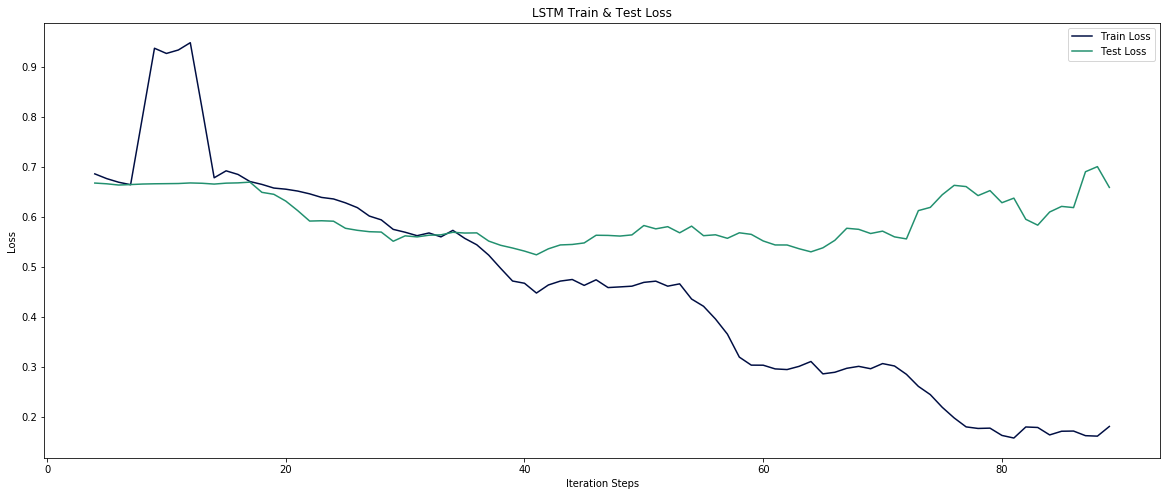

In [99]:
'''Plotting train and test loss'''
plt.figure(figsize=(20, 8))

plt.title('LSTM Train & Test Loss')
plt.plot(pd.Series(train_history).rolling(5).mean(), color='#000E43', label = 'Train Loss')
plt.plot(pd.Series(test_history).rolling(5).mean(), color='#22906F', label = 'Test Loss')
plt.xlabel('Iteration Steps')
plt.ylabel('Loss')
plt.legend()

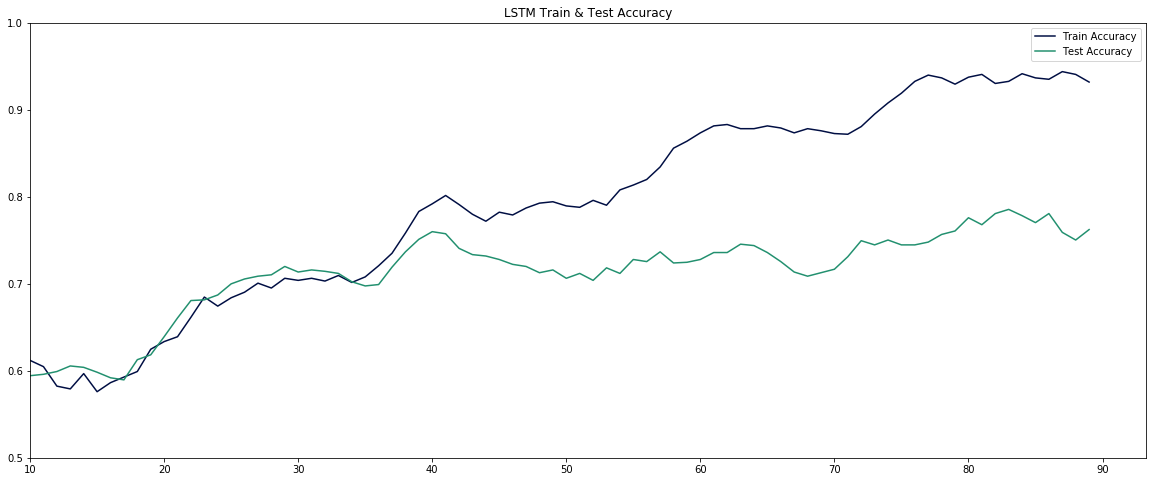

In [92]:
'''Plotting train and test accuracy'''
plt.figure(figsize=(20, 8))

plt.title('LSTM Train & Test Accuracy')
plt.plot(pd.Series(train_accuracy).rolling(5).mean(), color='#000E43', label = 'Train Accuracy')
plt.plot(pd.Series(test_accuracy).rolling(5).mean(), color='#22906F', label = 'Test Accuracy')
plt.xlim(10)
plt.ylim(0.5, 1)
plt.legend()

<br>

### **Evaluating with Examples**

**Commentary Review Pipeline**

In [35]:
def one_dim_pad(review: List[str], seq_length:int = 500) -> np.array:
    length = len(review)
    
    if length <= seq_length:
            padding    = list(np.zeros(seq_length-length))
            new_review = padding + review
             
    elif length > seq_length:
        new_review = review[0:seq_length]
        
    new_review = np.array(new_review)
    
    return new_review

In [40]:
def one_dim_text_processing(review: str, word_dictionary: Dict[str, int]) -> np.array:
    '''Cleans & Preprocesses a single string for the LSTM'''
    review = review.lower()
    review = ''.join([ch for ch in review if ch not in punctuation])
    review = word_tokenize(review)
    review = [word_dictionary[word] for word in review]
    review = one_dim_pad(review, 500)
    return torch.Tensor(review)

<br>

**Example Results**

In [101]:
negative_test = '''The director did not know how a comedy must be done.
                   There was no direction and the actors were terrible.
                   I did not like it, it was an absolute disaster.'''

In [102]:
positive_test  = '''This movie was amazing! I loved everything.
                    I will definitely watch a movie from this director again!'''

In [103]:
positive_review = text_processing(positive_test, word2int)
positive_review = positive_review[None, :]

In [104]:
negative_review = text_processing(negative_test, word2int)
negative_review = negative_review[None, :]

In [105]:
lstm.eval()
hidden = lstm.init_hidden(1)
pos, _ = lstm(positive_review.long(), hidden)
hidden = lstm.init_hidden(1)
neg, _ = lstm(negative_review.long(), hidden)

In [110]:
print(f'Positive Review Score: {round(pos.item(), 3)}\nNegative Review Score: {round(neg.item(), 3)}')

Positive Review Score: 0.996
Negative Review Score: 0.001


<br>

## **STEP 4: LDA Synthetic Data**

**Importing Data**

In [5]:
LDA_train = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'synth_train.csv'))
LDA_test  = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'synth_test.csv'))

**Text Preprocessing**

In [7]:
LDA_train = text_preprocessing(LDA_train, text_column='text')
LDA_test  = text_preprocessing(LDA_test,  text_column='text')

**Vocabulary Dictionary Mapping**

In [8]:
LDA_word2int, LDA_word4review = dictionary_mapping(LDA_train, LDA_test)

**Encoding Reviews & Labels**

In [9]:
LDA_encoded_review = [[LDA_word2int[word] for word in review] for review in LDA_word4review]

In [10]:
LDA_X_train , LDA_X_test = LDA_encoded_review[:5000], LDA_encoded_review[5000:]

In [11]:
LDA_y_train = [1 if label == 'pos' else 0 for label in LDA_train['label'].tolist()]
LDA_y_test  = [1 if label == 'pos' else 0 for label in LDA_test['label'].tolist()]

**Exploratory Data Analysis**

In [12]:
import matplotlib.pyplot as plt

In [13]:
lengths = [len(x) for x in LDA_encoded_review]

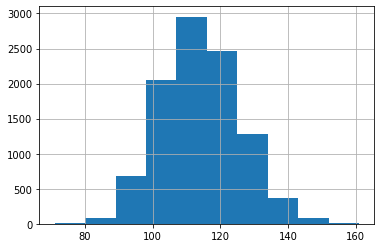

In [14]:
#Think of a better plot
pd.Series(lengths).hist()
plt.show()

In [15]:
pd.Series(lengths).describe()

count    10000.000000
mean     113.536200  
std      11.579616   
min      71.000000   
25%      105.000000  
50%      113.000000  
75%      121.000000  
max      161.000000  
dtype: float64

**Removing Outliers**

In [16]:
outlier = 200
#Remove outlier reviews: [10 words < review < 500 words]
LDA_train_outliers = [True if len(x)<=outlier else False for x in LDA_X_train]
LDA_test_outliers  = [True if len(x)<=outlier else False for x in LDA_X_test]

In [17]:
#Train outlier removal
LDA_X_train = [x for x, y in zip(LDA_X_train, LDA_train_outliers) if y == True]
LDA_y_train = [x for x, y in zip(LDA_y_train, LDA_train_outliers) if y == True]

#Test outlier removal
LDA_X_test = [x for x, y in zip(LDA_X_test, LDA_test_outliers) if y == True]
LDA_y_test = [x for x, y in zip(LDA_y_test, LDA_test_outliers) if y == True]

**Padding**

In [18]:
LDA_X_train = pad(LDA_X_train, outlier)
LDA_X_test  = pad(LDA_X_test, outlier)

**Dataloaders**

In [19]:
LDA_data_train = torch.utils.data.TensorDataset(torch.from_numpy(LDA_X_train).long(), torch.from_numpy(np.array(LDA_y_train)).float())
LDA_data_test  = torch.utils.data.TensorDataset(torch.from_numpy(LDA_X_test).long(), torch.from_numpy(np.array(LDA_y_test)).float())

In [20]:
batch = 500
LDA_train_loader = torch.utils.data.DataLoader(LDA_data_train, shuffle=True, batch_size=batch, drop_last=True)
LDA_test_loader  = torch.utils.data.DataLoader(LDA_data_test, shuffle= True, batch_size=batch, drop_last=True)

**Initializing Network**

In [30]:
LDA_vocabulary = len(LDA_word2int) + 1

In [31]:
lda_lstm = LSTM(LDA_vocabulary, n_output=1, n_embedding=30, n_hidden=64, n_layers=2)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lda_lstm.parameters(), lr=0.001)

<br>

### Train

In [32]:
epochs = 10
lda_train_loss = 0
lda_test_loss  = 0
lda_train_history  = []
lda_test_history   = []
lda_train_accuracy = []
lda_test_accuracy  = []
    
for epoch in range(epochs):
        
        lda_train_loss = 0
        lda_test_loss  = 0
        hidden = lda_lstm.init_hidden(batch)
        
        lda_lstm.train()
        for _, data in enumerate(LDA_train_loader):
            
            optimizer.zero_grad()
            
            X_train, y_train = data
            X_train, y_train = Variable(torch.squeeze(X_train)), Variable(torch.squeeze(y_train))
            
            #Forward pass
            hidden = tuple([each.data for each in hidden])
            y_hat, hidden = lda_lstm(X_train, hidden)
            
            #Calculating loss and backpropagating
            loss  = criterion(y_hat, y_train)
            loss.backward()
            
            #Clipping Gradients and taking a step
            nn.utils.clip_grad_norm_(lda_lstm.parameters(), 5)
            optimizer.step()
            
            #Storing loss results
            lda_train_loss += loss.item() 
            lda_train_history.append(loss.item())
            
            #Calculating Accuracy
            predictions = torch.round(y_hat.squeeze())
            num_correct = predictions.eq(y_train.float().view_as(predictions))
            correct     = np.squeeze(num_correct.numpy())
            accuracy    = np.sum(correct)/batch
            lda_train_accuracy.append(accuracy)
            
        hidden = lda_lstm.init_hidden(batch)
        
        #print('test')
        lda_lstm.eval()
        for _, data in enumerate(LDA_test_loader):
            
            X_test, y_test = data
            X_test, y_test = torch.squeeze(X_test), torch.squeeze(y_test)
            
            hidden = tuple([each.data for each in hidden])
            y_hat, hidden = lda_lstm(X_test, hidden)
            
            #Checking Loss
            loss = criterion(y_hat, y_test)
            lda_test_loss += loss.item()
            lda_test_history.append(loss.item())
            
            #Calculating Accuracy
            predictions = torch.round(y_hat.squeeze())
            num_correct = predictions.eq(y_test.float().view_as(predictions))
            correct     = np.squeeze(num_correct.numpy())
            accuracy    = np.sum(correct)/batch
            lda_test_accuracy.append(accuracy)
            
        
        lda_train_loss = str(lda_train_loss*batch/len(LDA_train_loader.dataset))[:5]
        lda_test_loss  = str(lda_test_loss*batch/len(LDA_test_loader.dataset))[:5]
        
        
        string = f'''| Epoch: {epoch + 1}   | Train Loss: {lda_train_loss} | Test Loss: {str(lda_test_loss)} |'''
        print('-'*len(string)); print(string); print('-'*len(string))

-----------------------------------------------------
| Epoch: 1   | Train Loss: 0.672 | Test Loss: 0.631 |
-----------------------------------------------------
-----------------------------------------------------
| Epoch: 2   | Train Loss: 0.501 | Test Loss: 0.244 |
-----------------------------------------------------
-----------------------------------------------------
| Epoch: 3   | Train Loss: 0.120 | Test Loss: 0.051 |
-----------------------------------------------------
-----------------------------------------------------
| Epoch: 4   | Train Loss: 0.041 | Test Loss: 0.029 |
-----------------------------------------------------
-----------------------------------------------------
| Epoch: 5   | Train Loss: 0.018 | Test Loss: 0.013 |
-----------------------------------------------------
-----------------------------------------------------
| Epoch: 6   | Train Loss: 0.011 | Test Loss: 0.009 |
-----------------------------------------------------
----------------------------

In [33]:
PATH = os.path.join(os.getcwd(), 'Models', 'LDA_Sentiment_LSTM')
torch.save(lda_lstm, PATH)

<br>

**Plotting Results**

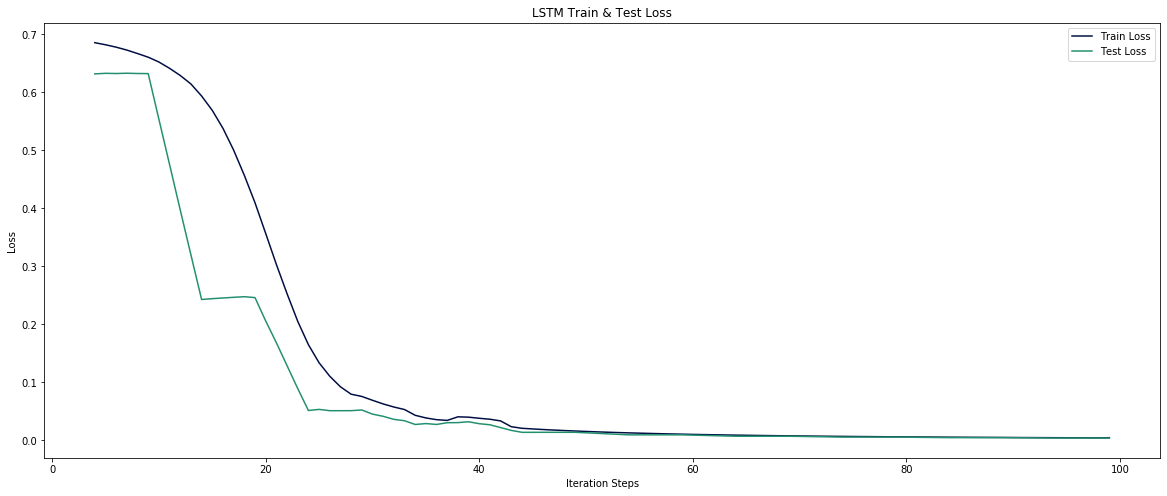

In [34]:
'''Plotting train and test loss'''
plt.figure(figsize=(20, 8))

plt.title('LSTM Train & Test Loss')
plt.plot(pd.Series(lda_train_history).rolling(5).mean(), color='#000E43', label = 'Train Loss')
plt.plot(pd.Series(lda_test_history).rolling(5).mean(), color='#22906F', label = 'Test Loss')
plt.xlabel('Iteration Steps')
plt.ylabel('Loss')
plt.legend()

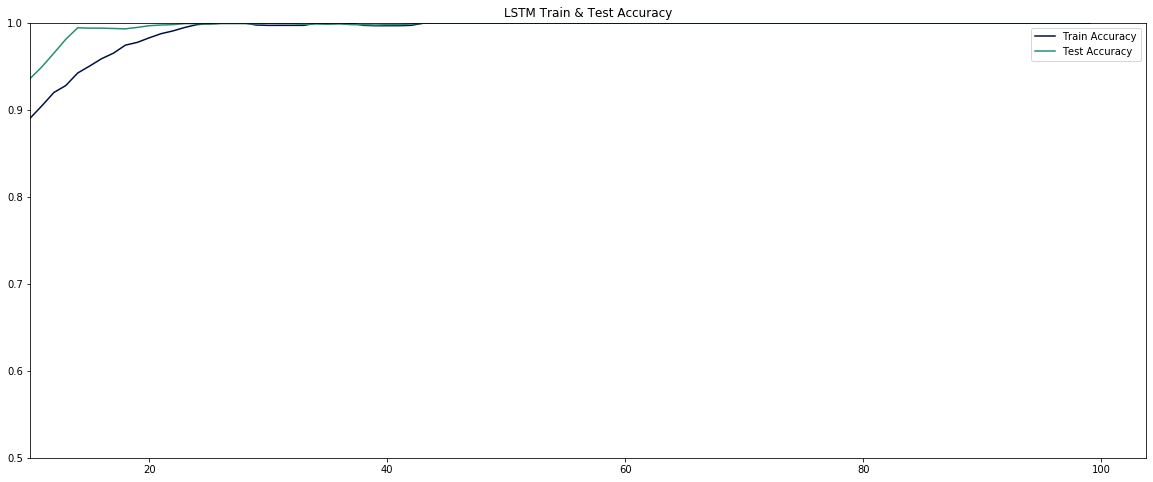

In [37]:
'''Plotting train and test accuracy'''
plt.figure(figsize=(20, 8))

plt.title('LSTM Train & Test Accuracy')
plt.plot(pd.Series(lda_train_accuracy).rolling(5).mean(), color='#000E43', label = 'Train Accuracy')
plt.plot(pd.Series(lda_test_accuracy).rolling(5).mean(), color='#22906F', label = 'Test Accuracy')
plt.xlim(10)
plt.ylim(0.5, 1)
plt.legend()